In [5]:
# reference: https://github.com/bryanlimy/V1T

In [6]:
import torch
import random
import numpy as np
import scipy.optimize as opt
from tqdm import tqdm
from nnfabrik.builder import get_data, get_model
from torch.utils.data import TensorDataset, DataLoader
from einops import rearrange, einsum
from neuralpredictors.training import eval_state, device_state
import matplotlib.pyplot as plt

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (1, 144, 256)

### Plot aRFs

In [92]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
def set_xticks(
    axis,
    ticks_loc,
    ticks = None,
    label = "",
    tick_fontsize = None,
    label_fontsize = None,
):
    axis.set_xticks(ticks_loc)
    if ticks is None:
        ticks = ticks_loc
    axis.set_xticklabels(ticks, fontsize=tick_fontsize)
    if label:
        axis.set_xlabel(label, fontsize=label_fontsize)

def set_yticks(
    axis,
    ticks_loc,
    ticks = None,
    label = "",
    tick_fontsize = None,
    label_fontsize = None,
):
    axis.set_yticks(ticks_loc)
    if ticks is None:
        ticks = ticks_loc
    axis.set_yticklabels(ticks, fontsize=tick_fontsize)
    if label:
        axis.set_ylabel(label, fontsize=label_fontsize)
        
def set_ticks_params(
    axis, length = 3, pad = 2
):
    axis.tick_params(axis="both", which="both", length=length, pad=pad, colors="black")

def save_figure(figure: plt.Figure, filename: str, dpi: int = 120, close: bool = True):
    dirname = os.path.dirname(filename)
    if dirname and not os.path.exists(dirname):
        os.makedirs(dirname)
    figure.savefig(
        filename, dpi=dpi, bbox_inches="tight", pad_inches=0.01, transparent=True
    )
    if close:
        plt.close(figure)
        
def remove_spines(axis):
    """remove all spines"""
    axis.spines["top"].set_visible(False)
    axis.spines["left"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.spines["bottom"].set_visible(False)

In [96]:
def load_results(filename: str):
    with open(filename, "rb") as file:
        results = pickle.load(file)
    return results

results_23656 = load_results("./aRFs_23656-14-22_ensemble.pkl")
results_22846 = load_results("./aRFs_22846-10-16_ensemble.pkl")
aRFs = results_22846["aRFs"]
parameters = results_22846["popts"]

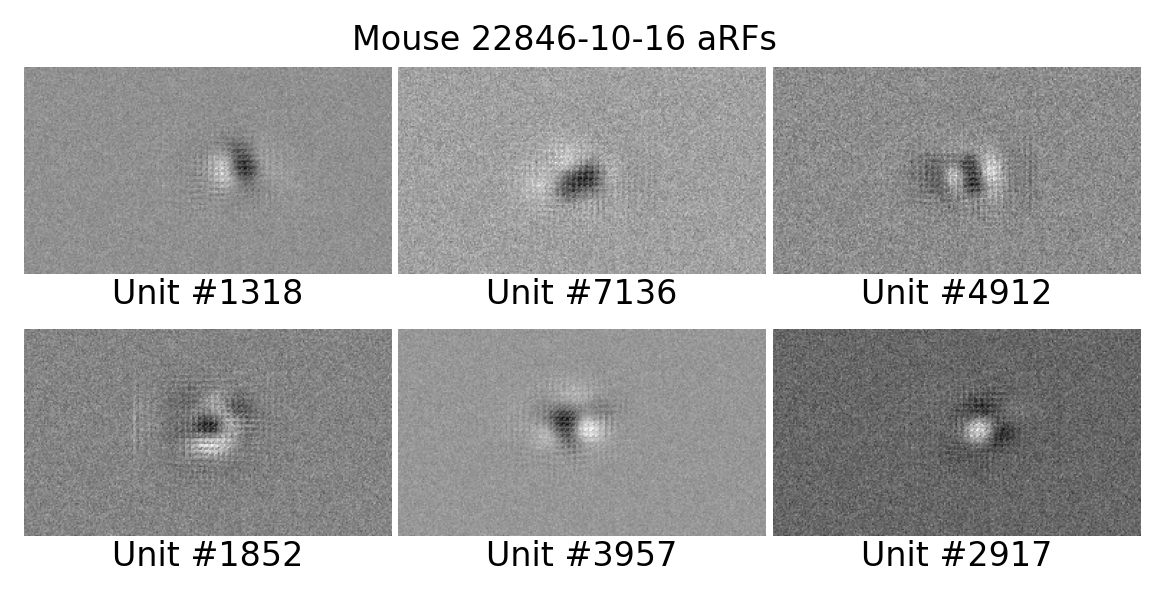

In [212]:
random_units = np.random.choice(results_22846["aRFs"].shape[0], size=6, replace=False)
normalize = lambda a: (a - a.min()) / (a.max() - a.min())

def Gaussian2d(
    xy: np.ndarray,
    amplitude: float,
    xo: float,
    yo: float,
    sigma_x: float,
    sigma_y: float,
    theta: float,
    offset: float,
):

    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta) ** 2) / (2 * sigma_x**2) + (np.sin(theta) ** 2) / (
        2 * sigma_y**2
    )
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (
        4 * sigma_y**2
    )
    c = (np.sin(theta) ** 2) / (2 * sigma_x**2) + (np.cos(theta) ** 2) / (
        2 * sigma_y**2
    )
    g = offset + amplitude * np.exp(
        -(a * ((x - xo) ** 2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo) ** 2))
    )
    return g.ravel()


def plot_aRF(axis, aRF: np.ndarray, parameter: np.ndarray, title: str = None):
    height, width = aRF.shape[1], aRF.shape[2]
    x, y = np.linspace(0, width - 1, width), np.linspace(0, height - 1, height)
    x, y = np.meshgrid(x, y)
    aRF = normalize(aRF)
    axis.imshow(aRF[0], cmap="gray", vmin=0, vmax=1)
    
    if title is not None:
        axis.set_xlabel(title, labelpad=1, fontsize=10)
    axis.set_xticks([])
    axis.set_yticks([])
    remove_spines(axis=axis)
    
def plot_aRFs(
    aRFs: np.ndarray,
    units: np.ndarray,
    parameters: np.ndarray = None,
    title: str = None,
    filename: str = None,
):
    nrows, ncols = 2, 3

    figure, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        gridspec_kw={"wspace": 0.02, "hspace": 0.2},
        figsize=(6, 2.6),
        dpi=240,
    )
    axes = axes.flatten()

    for i, unit in enumerate(units):
        plot_aRF(
            axis=axes[i],
            aRF=aRFs[unit],
            parameter=parameters[unit],
            title=f"Unit #{unit}",
        )

    if title is not None:
        pos = axes[0].get_position()
        figure.suptitle(title, fontsize=10, y=pos.y1 + 0.07)

    if filename is not None:
        save_figure(figure, filename=filename, dpi=240, close=False)

    plt.show()
    plt.close(figure)
    
plot_aRFs(
    aRFs=results_22846["aRFs"],
    parameters=results_22846["popts"],
    title="Mouse 22846-10-16 aRFs",
    filename=None,
    units=random_units,
)

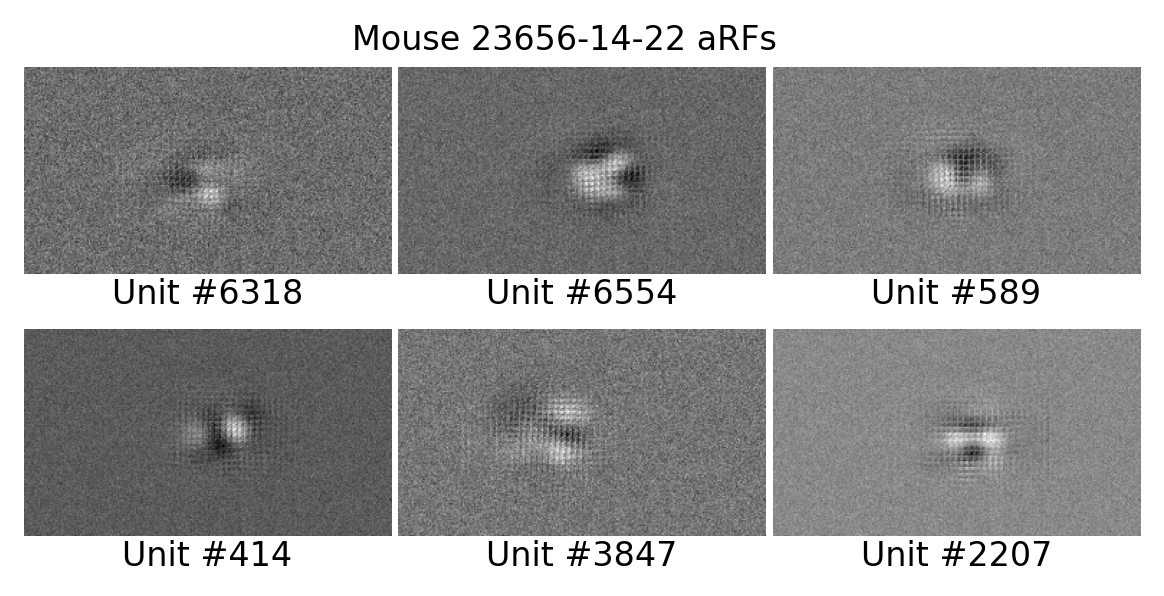

In [180]:
plot_aRFs(
    aRFs=results_23656["aRFs"],
    parameters=results_23656["popts"],
    title="Mouse 23656-14-22 aRFs",
    filename=None,
    units=random_units,
)

### aRFs vs. Neuron performances

In [248]:
def plot_aRF(axis, aRF: np.ndarray, parameter: np.ndarray, title: str = None):
    height, width = aRF.shape[1], aRF.shape[2]
    x, y = np.linspace(0, width - 1, width), np.linspace(0, height - 1, height)
    x, y = np.meshgrid(x, y)
    aRF = normalize(aRF)
    axis.imshow(aRF[0], cmap="gray", vmin=0, vmax=1)
    
    if title is not None:
        axis.set_xlabel(title, labelpad=1, fontsize=13)
    axis.set_xticks([])
    axis.set_yticks([])
    remove_spines(axis=axis)
    
def plot_aRFs(
    aRFs: np.ndarray,
    units: np.ndarray,
    corrs: np.ndarray,
    parameters: np.ndarray = None,
    title: str = None,
    filename: str = None,
):
    nrows, ncols = 5, 7

    figure, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(12, 6),
        dpi=240,
    )
    axes = axes.flatten()

    for i, unit in enumerate(units):
        plot_aRF(
            axis=axes[i],
            aRF=aRFs[unit],
            parameter=parameters[unit],
            title=f"Unit #{unit}\n{corrs[unit]:.03f}",
        )

    if title is not None:
        pos = axes[0].get_position()
        figure.suptitle(title, fontsize=13, y=pos.y1 + 0.1)

    if filename is not None:
        save_figure(figure, filename=filename, dpi=240, close=False)

    plt.tight_layout()
    plt.show()
    plt.close(figure)

In [203]:
performance = open("./performances/performances_per_neuron.10.pkl", "rb")
performances_per_neuron = pickle.load(performance)
performance.close()

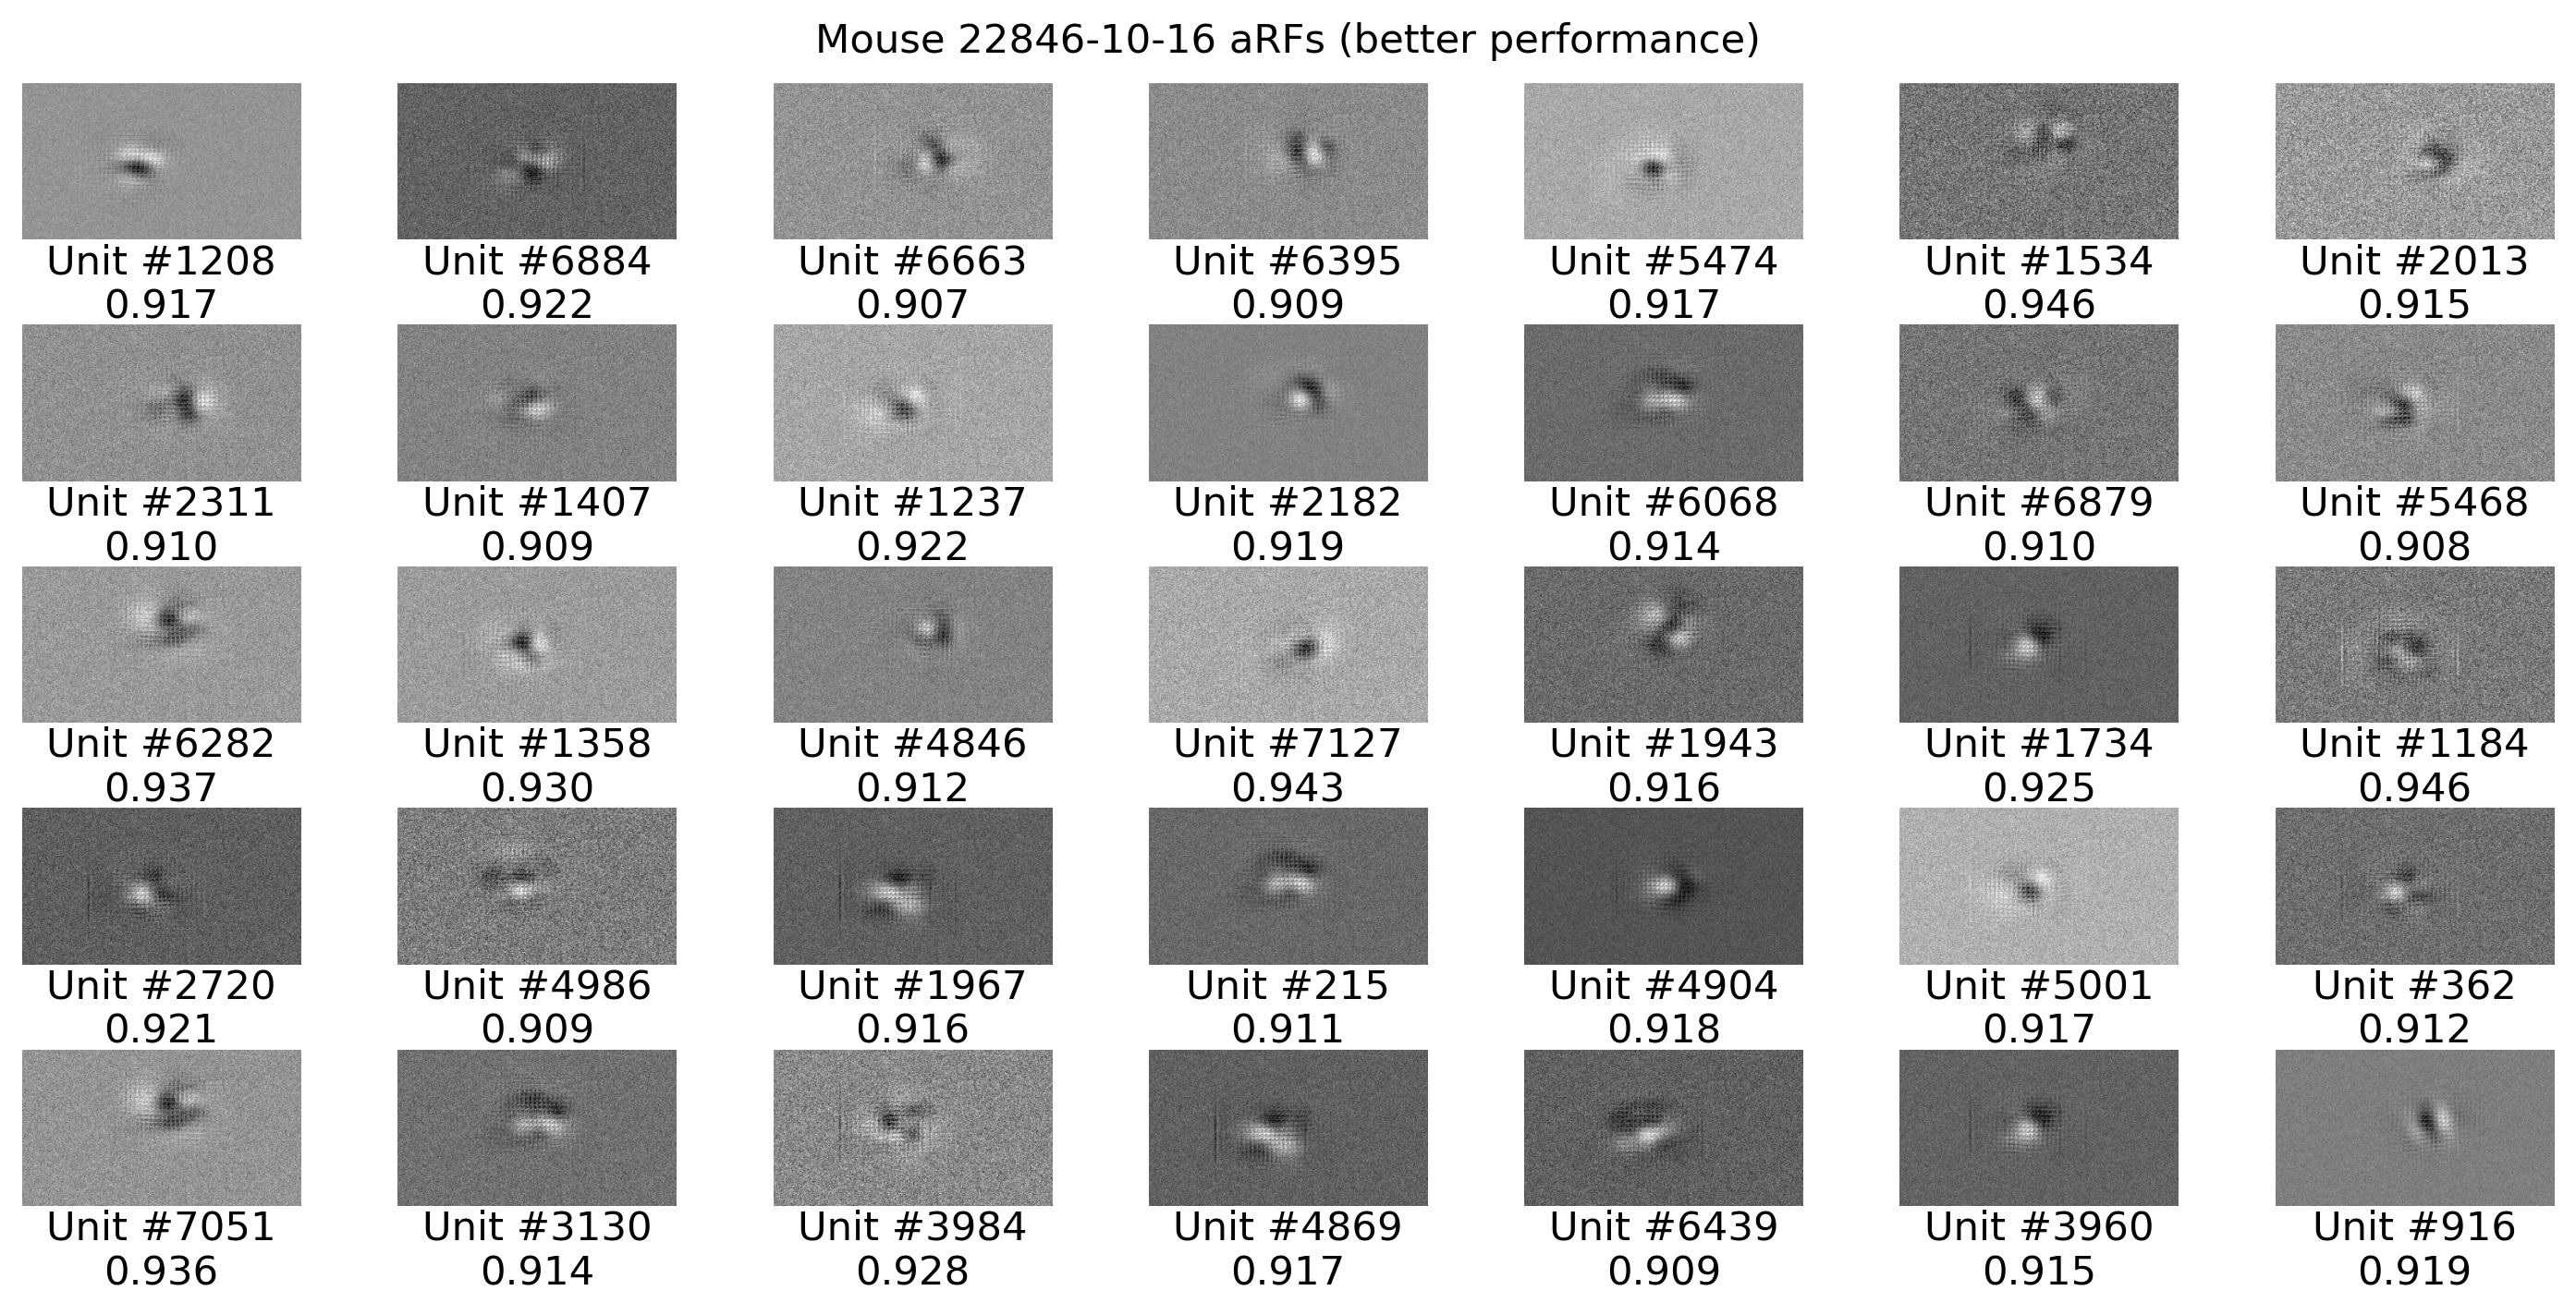

In [277]:
best_neurons = np.argpartition(performances_per_neuron["22846-10-16"]["Correlation to Average"], -100)[-100:]
units = np.random.choice(best_neurons, size=35, replace=False)
plot_aRFs(
    aRFs=results_22846["aRFs"],
    parameters=results_22846["popts"],
    title="Mouse 22846-10-16 aRFs (better performance)",
    filename=None,
    units=units,
    corrs=performances_per_neuron["22846-10-16"]["Correlation to Average"],
)

In [120]:
def load_centers(popts: np.ndarray):
    x, y = popts[:, 1], popts[:, 2]
    x, y = x[~np.isnan(x) & ~np.isinf(x)], y[~np.isnan(y) & ~np.isinf(y)]
    indexes = np.where((x < IMAGE_SIZE[2]) & (x > 0) & (y < IMAGE_SIZE[1]) & (y > 0))
    x = x[indexes]
    y = y[indexes]
    return x, y

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_32762/679997175.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


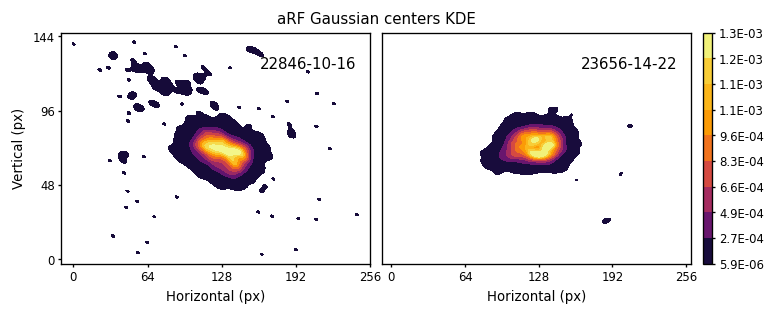

In [190]:
m1_x, m1_y = load_centers(results_22846["popts"])
m2_x, m2_y = load_centers(results_23656["popts"])

TICK_FONTSIZE, LABEL_FONTSIZE, TITLE_FONTSIZE = 7, 8, 9
figure, axes = plt.subplots(
    nrows=1,
    ncols=3,
    gridspec_kw={"wspace": 0.06, "hspace": 0.0, "width_ratios": [1, 1, 0.03]},
    figsize=(7, 2.5),
    dpi=120,
)

thresh, levels = 0.01, 10
kde_kw = {
    "fill": True,
    "levels": np.linspace(thresh, 1.0, levels),
    "thresh": thresh,
    "cmap": "inferno",
}
sns.kdeplot(
    x=m1_x,
    y=m1_y,
    ax=axes[0],
    **kde_kw,
    label="Mouse 22846-10-16",
)
sns.kdeplot(
    x=m2_x,
    y=m2_y,
    ax=axes[1],
    **kde_kw,
    label="Mouse 23656-14-22",
    cbar=True,
    cbar_ax=axes[2],
)
axes[0].legend(frameon=False)
axes[1].legend(frameon=False)
axes[0].set_title("22846-10-16", fontsize=TITLE_FONTSIZE, y=0.8, x=0.8)
axes[1].set_title("23656-14-22", fontsize=TITLE_FONTSIZE, y=0.8, x=0.8)

x_range = np.linspace(0, IMAGE_SIZE[2], 5)
y_range = np.linspace(0, IMAGE_SIZE[1], 4)

set_xticks(
    axis=axes[0],
    ticks_loc=x_range,
    ticks=x_range.astype(int),
    label="Horizontal (px)",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)
set_yticks(
    axis=axes[0],
    ticks_loc=y_range,
    ticks=y_range.astype(int),
    label="Vertical (px)",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)

set_xticks(
    axis=axes[1],
    ticks_loc=x_range,
    ticks=x_range.astype(int),
    label="Horizontal (px)",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)
axes[1].set_yticks([])
axes[1].set_ylim(0, IMAGE_SIZE[1])

ticks_loc = axes[2].get_yticks()
set_yticks(
    axis=axes[2],
    ticks_loc=ticks_loc,
    ticks=[f"{tick:.1E}" for tick in ticks_loc],
    tick_fontsize=TICK_FONTSIZE,
)

for ax in axes:
    set_ticks_params(axis=ax, length=2)

pos = axes[0].get_position()
figure.suptitle(
    "aRF Gaussian centers KDE",
    fontsize=TITLE_FONTSIZE,
    y=pos.y1 + 0.07,
)

plt.tight_layout()


In [187]:
def load_sigmas(popts: np.ndarray):
    indexes = np.where((popts[:, 1] < IMAGE_SIZE[2]) & (popts[:, 1] > 0) & (popts[:, 2] < IMAGE_SIZE[1]) & (popts[:, 2] > 0))
    popts = popts[indexes]
    x, y = popts[:, 3], popts[:, 4]
    x, y = np.abs(x[~np.isnan(x) & ~np.isinf(x)]), np.abs(y[~np.isnan(y) & ~np.isinf(y)])
    return x, y

Text(0.5, 1.0, 'aRF Gaussian $\\sigma$ distributions')

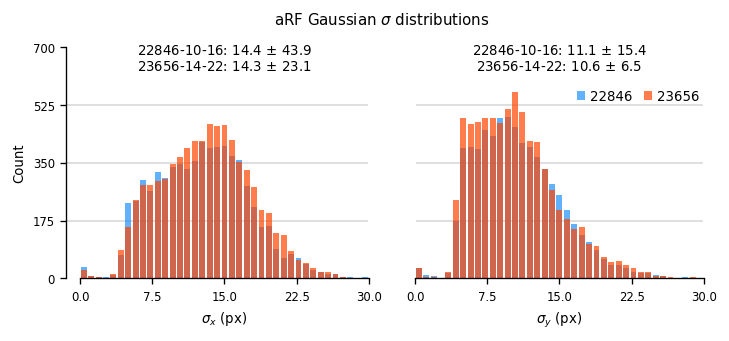

In [201]:
m1_sigma_x, m1_sigma_y = load_sigmas(results_22846["popts"])
m2_sigma_x, m2_sigma_y = load_sigmas(results_23656["popts"])

figure, axes = plt.subplots(
    nrows=1,
    ncols=2,
    gridspec_kw={"wspace": 0.06, "hspace": 0.0},
    figsize=(7, 2.5),
    dpi=120,
)
alpha = 0.7
x_max = 30
y_max = 700
bins = np.linspace(0, x_max, 40)

axes[0].hist(m1_sigma_x, bins=bins, alpha=alpha, color="dodgerblue", label="22846", rwidth=0.8)
axes[0].hist(m2_sigma_x, bins=bins, alpha=alpha, color="orangered", label="23656", rwidth=0.8)

axes[1].hist(m1_sigma_y, bins=bins, alpha=alpha, color="dodgerblue", label="22846", rwidth=0.8)
axes[1].hist(m2_sigma_y, bins=bins, alpha=alpha, color="orangered", label="23656", rwidth=0.8)

x_range = np.linspace(0, x_max, 5)
y_range = np.linspace(0, y_max, 5)

set_xticks(
    axis=axes[0],
    ticks_loc=x_range,
    ticks=x_range.round(2),
    label=r"$\sigma_x$ (px)",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)
set_yticks(
    axis=axes[0],
    ticks_loc=y_range,
    ticks=y_range.astype(int),
    label="Count",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)

set_xticks(
    axis=axes[1],
    ticks_loc=x_range,
    ticks=x_range.round(2),
    label=r"$\sigma_y$ (px)",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)
axes[1].set_yticks([])
axes[1].set_ylim(0, y_max)

sns.despine(ax=axes[0], top=True, right=True, trim=True)
sns.despine(ax=axes[1], top=True, right=True, left=True, trim=True)

# plot y-axis grid lines
for y_value in y_range:
    if 0 < y_value < y_max:
        axes[0].axhline(
            y_value, xmax=0.95, color="gray", alpha=0.3, linewidth=1, zorder=0
        )
        axes[1].axhline(
            y_value,
            xmin=0.05,
            xmax=0.95,
            color="gray",
            alpha=0.3,
            linewidth=1,
            zorder=0,
        )


title1 = rf"22846-10-16: {np.mean(m1_sigma_x):.01f} $\pm$ {np.std(m1_sigma_x):.01f}" + "\n"
title1 += rf"23656-14-22: {np.mean(m2_sigma_x):.01f} $\pm$ {np.std(m2_sigma_x):.01f}"
axes[0].set_title(title1, fontsize=LABEL_FONTSIZE, pad=0, y = 0.9)


title2 = rf"22846-10-16: {np.mean(m1_sigma_y):.01f} $\pm$ {np.std(m1_sigma_y):.01f}" + "\n"
title2 += rf"23656-14-22: {np.mean(m2_sigma_y):.01f} $\pm$ {np.std(m2_sigma_y):.01f}"
axes[1].set_title(title2, fontsize=LABEL_FONTSIZE, pad=0, y = 0.9)

axes[1].legend(
    loc="upper right",
    bbox_to_anchor=(0.98, 0.87),
    ncols=2,
    frameon=False,
    handletextpad=0.35,
    handlelength=0.6,
    markerscale=0.8,
    columnspacing=0.85,
    fontsize=LABEL_FONTSIZE,
)

pos = axes[0].get_position()
figure.suptitle(
    r"aRF Gaussian $\sigma$ distributions",
    fontsize=TITLE_FONTSIZE,
    y=pos.y1 + 0.12,
)